# CNN+LSTM 전력 수요 예측 

### <목차>

#### 1. 모듈 임포트
<br/>

#### 2. 데이터 합본 저장
##### ㅤ-3년치 데이터
##### ㅤ-4년치 데이터
<br/>

#### 3. 그래프 확인
##### ㅤ-각 연도별 csv 데이터 로드
##### ㅤ-plt 그래프 함수
##### ㅤ-2013
##### ㅤ-2014
##### ㅤ-2015
##### ㅤ-2013-2015
<br/>

#### 4. 데이터 정규화 
##### ㅤ-Min-Max Scaling 이용, 4년치 학습 데이터 정규화
<br/>

#### 5. 데이터 연관성 분석
<br/>

#### 6. 이상치 처리
##### ㅤ-이상치 확인 함수 생성
##### ㅤ-분위별 이상치 1차 검색
##### ㅤ-이상치 치환
##### ㅤ-처리 후 잔여 개수 확인
<br/>

#### 7. 데이터셋 편집
<br/>

#### 8. 딥러닝 모델
<br/>

#### 9. 결과 표시
##### ㅤ-그래프 표시
##### ㅤ-그래프 비교 결과
##### ㅤ-성능 측정 지표
<br/>

#### 10. 예측값과 실제값 결과 csv 파일 저장
##### ㅤ-1년 단위 저장
##### ㅤ-1달 단위 저장
##### ㅤ-일주일 단위 저장

### <화면 가로 확장>

In [1]:
# 화면 가로 확장 코드 (기본 width 50%)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 1. 모듈 임포트

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf
import csv
import os
import datetime
import time

### <GPU 확인>

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
Data_4Y = pd.read_csv('./Combined_Data/House1_Ch1_Combined_Data_13-16.csv', encoding='cp949')
Data_4Y.insert(3,'Unix_Time','')

for i in range(len(Data_4Y)):
    Y=int(Data_4Y['Graph_Date'][i][:4])
    M=int(Data_4Y['Graph_Date'][i][5:7])
    D=int(Data_4Y['Graph_Date'][i][8:10])
    date = datetime.datetime(Y, M, D)
    unix=int(time.mktime(date.timetuple())/1000) # 시,분,초 정보는 0으로 일괄처리 되기 때문에 1000으로 나눠서 뒤 3자리수는 제거
    Data_4Y['Unix_Time'][i]=unix
Data_4Y.info()

C:\Users\82108\AppData\Local\Temp/ipykernel_3764/1308127445.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_4Y['Unix_Time'][i]=unix


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   35040 non-null  int64  
 1   DateTime     35040 non-null  int64  
 2   Graph_Date   35040 non-null  object 
 3   Unix_Time    35040 non-null  object 
 4   Day          35040 non-null  object 
 5   Holiday      35040 non-null  int64  
 6   Seq          35040 non-null  int64  
 7   Watt         35040 non-null  int64  
 8   Temp('C)     35040 non-null  float64
 9   Humidity(%)  35040 non-null  float64
 10  CPI          35040 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 2.9+ MB


In [5]:
Data_4Y

,Unnamed: 0,DateTime,Graph_Date,Unix_Time,Day,Holiday,Seq,Watt,Temp('C),Humidity(%),CPI
0,0,20130101,2013-01-01,1356966,화,1,0,2495,10.0,84.5,2.7
1,1,20130101,2013-01-01,1356966,화,1,1,2482,9.0,87.0,2.7
2,2,20130101,2013-01-01,1356966,화,1,2,2441,8.5,87.0,2.7
3,3,20130101,2013-01-01,1356966,화,1,3,265,8.0,81.0,2.7
4,4,20130101,2013-01-01,1356966,화,1,4,260,8.0,78.5,2.7
...,...,...,...,...,...,...,...,...,...,...,...
35035,35035,20161231,2016-12-31,1483110,토,1,19,380,9.0,84.5,1.6
35036,35036,20161231,2016-12-31,1483110,토,1,20,1743,9.0,82.0,1.6
35037,35037,20161231,2016-12-31,1483110,토,1,21,941,8.0,87.0,1.6
35038,35038,20161231,2016-12-31,1483110,토,1,22,597,8.0,87.0,1.6


### 4. 데이터 정규화

#### Min-Max Scaling 이용, 4년치 학습 데이터 정규화

In [6]:
from sklearn.preprocessing import MinMaxScaler

# 정규화 과정을 거쳐 데이터 범위를 원하는 범위로 제한. 그래프는 동일하나 손실 정도를 확인하기에 더 좋음.
# 배치 정규화는 기울기 소멸 문제를 해결하기는 좋으나, RNN의 경우 계층별로 미니 정규화 적용이 필요해 모델이 복잡해지고 효율이 저하됨.
Data_4Y.sort_index(ascending=False).reset_index(drop=True)

scaler = MinMaxScaler()
#scale_cols = ['Unix_Time', 'Holiday', 'Watt', "Temp('C)", 'Humidity(%)', 'CPI']
scale_cols = ['Holiday', 'Watt', "Temp('C)", 'Humidity(%)', 'CPI']
Data_4Y_scaled = scaler.fit_transform(Data_4Y[scale_cols])
Data_4Y_scaled = pd.DataFrame(Data_4Y_scaled)
Data_4Y_scaled.columns = scale_cols

Data_4Y_scaled.insert(0, 'DateTime', Data_4Y['DateTime'])
Data_4Y_scaled.insert(1, 'Graph_Date', Data_4Y['Graph_Date'])
Data_4Y_scaled

,DateTime,Graph_Date,Holiday,Watt,Temp('C),Humidity(%),CPI
0,20130101,2013-01-01,1.0,0.270038,0.360000,0.812121,0.933333
1,20130101,2013-01-01,1.0,0.268530,0.333333,0.842424,0.933333
2,20130101,2013-01-01,1.0,0.263775,0.320000,0.842424,0.933333
3,20130101,2013-01-01,1.0,0.011368,0.306667,0.769697,0.933333
4,20130101,2013-01-01,1.0,0.010788,0.306667,0.739394,0.933333
...,...,...,...,...,...,...,...
35035,20161231,2016-12-31,1.0,0.024707,0.333333,0.812121,0.566667
35036,20161231,2016-12-31,1.0,0.182809,0.333333,0.781818,0.566667
35037,20161231,2016-12-31,1.0,0.089781,0.306667,0.842424,0.566667
35038,20161231,2016-12-31,1.0,0.049878,0.306667,0.842424,0.566667


### 5. 데이터 연관성 분석

In [7]:
import scipy.stats as stats

# 피어슨 stat을 이용하면 피어슨 상관계수와 p-value값이 출력되는데 상관계수는 양 or 음의 비례관계 정도를, p-value는 상관 정도를 보여준다. (0에 가까울수록 영향이 크다.)

Correlation=stats.pearsonr(Data_4Y_scaled['Holiday'], Data_4Y_scaled['Watt'])
print('< Holiday - Watt >')
print('P-value ==>> %.3f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled["Temp('C)"], Data_4Y_scaled['Humidity(%)'])
print('< Temp - Humidity >')
print('P-value ==>> %.3f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled["Temp('C)"], Data_4Y_scaled['Watt'])
print('< Temp - Watt >')
print('P-value ==>> %.3f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled['Humidity(%)'], Data_4Y_scaled['Watt'])
print('< Humidity - Watt >')
print('P-value ==>> %.3f\n' %Correlation[1])

Correlation=stats.pearsonr(Data_4Y_scaled['CPI'], Data_4Y_scaled['Watt'])
print('< CPI - Watt >')
print('P-value ==>> %.3f\n' %Correlation[1])

< Holiday - Watt >
P-value ==>> 0.000

< Temp - Humidity >
P-value ==>> 0.000

< Temp - Watt >
P-value ==>> 0.169

< Humidity - Watt >
P-value ==>> 0.000

< CPI - Watt >
P-value ==>> 0.000



### 6. 이상치 처리

#### 이상치 확인 함수 생성

In [8]:
def get_outlier(df=None, column=None, weight=None):
    quantile_5 = np.percentile(df[column].values, 5)
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_50 = np.percentile(df[column].values, 50)
    quantile_75 = np.percentile(df[column].values, 75)
    quantile_95 = np.percentile(df[column].values, 95)
    
    IQR = quantile_75 - quantile_25
    IQR_weight = IQR * weight

    lowest_val = quantile_25-IQR_weight
    highest_val = quantile_75+IQR_weight
    
    outlier_index_lowest = df[column][df[column] < quantile_5].index
    outlier_index_low = df[column][df[column] < lowest_val].index
    outlier_index_high = df[column][df[column] > highest_val].index
    outlier_index_highest = df[column][df[column] > quantile_95].index
    
    return outlier_index_lowest, outlier_index_low, outlier_index_high, outlier_index_highest, quantile_5, quantile_25, quantile_50, quantile_75, quantile_95

#### 분위별 이상치 1차 검색 (외부 울타리)

In [9]:
WEIGHT=2.5
Lowest_list = get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[0]
Highest_list = get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[3]

print('Lowest Outlier ==>> {}\n'.format(Lowest_list))
print('Low Outlier ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[1]))
print('High Outlier ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[2]))
print('Highest Outlier ==>> {}\n'.format(Highest_list))

print('5% Value ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[4]))
print('25% Value ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[5]))
print('50% Value ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[6]))
print('75% Value ==>> {}\n'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[7]))
print('95% Value ==>> {}'.format(get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[8]))

Lowest Outlier ==>> Int64Index([  241,   242,   265,   266,   289,   290,   313,   314,   337,
              338,
            ...
            34986, 34987, 34992, 34993, 34996, 34997, 35001, 35005, 35008,
            35010],
           dtype='int64', length=1680)

Low Outlier ==>> Int64Index([], dtype='int64')

High Outlier ==>> Int64Index([7671, 11721, 12007, 14225, 15250, 18547, 24660, 25184, 28567,
            35025],
           dtype='int64')

Highest Outlier ==>> Int64Index([    8,    56,    79,    90,   111,   131,   186,   190,   199,
              211,
            ...
            34666, 34688, 34783, 34832, 34836, 34880, 34906, 34907, 35025,
            35026],
           dtype='int64', length=1752)

5% Value ==>> 0.006843753624869504

25% Value ==>> 0.014499478018791326

50% Value ==>> 0.03932258438696207

75% Value ==>> 0.24834705950585778

95% Value ==>> 0.47988052430112466


#### 이상치 치환 (조정된 외부 울타리)

In [10]:
"""
단순 치환이 아니라 루트(가중치)를 각각의 값에 곱하거나 나눠서 처리
5% 미만은 곱해주고, 95% 초과는 나눠줌.
그러면 값들이 똑같아져 학습에 악영향을 주는 것도 방지할 뿐더러 이상치 범위도 처리 가능함.
4분위 계산에서는 기존처럼 치환 but! 5%와 95% 처리후 처리가 되어서 4분위 처리에 중복으로 처리되는지 확인 필요!
"""

'\n단순 치환이 아니라 루트(가중치)를 각각의 값에 곱하거나 나눠서 처리\n5% 미만은 곱해주고, 95% 초과는 나눠줌.\n그러면 값들이 똑같아져 학습에 악영향을 주는 것도 방지할 뿐더러 이상치 범위도 처리 가능함.\n4분위 계산에서는 기존처럼 치환 but! 5%와 95% 처리후 처리가 되어서 4분위 처리에 중복으로 처리되는지 확인 필요!\n'

In [11]:
WEIGHT_2R=np.sqrt(WEIGHT)

for i in range(len(Lowest_list)):
    Data_4Y_scaled['Watt'][Lowest_list[i]] = Data_4Y_scaled['Watt'][Lowest_list[i]]*WEIGHT_2R
    
for i in range(len(Highest_list)):
    Data_4Y_scaled['Watt'][Highest_list[i]] = Data_4Y_scaled['Watt'][Highest_list[i]]/WEIGHT_2R

C:\Users\82108\AppData\Local\Temp/ipykernel_3764/2954332734.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_4Y_scaled['Watt'][Lowest_list[i]] = Data_4Y_scaled['Watt'][Lowest_list[i]]*WEIGHT_2R
C:\Users\82108\AppData\Local\Temp/ipykernel_3764/2954332734.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Data_4Y_scaled['Watt'][Highest_list[i]] = Data_4Y_scaled['Watt'][Highest_list[i]]/WEIGHT_2R


#### 이상치 처리 후 잔여 개수 확인

In [12]:
print('Quantity of Low Outlier ==>> {}\n'.format(len(get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[1])))
print('Quantity of High Outlier ==>> {}\n'.format(len(get_outlier(df=Data_4Y_scaled, column='Watt', weight=WEIGHT)[2])))

Quantity of Low Outlier ==>> 0

Quantity of High Outlier ==>> 0



### 7. 데이터셋 편집

In [13]:
TEST_SIZE = 8760 # 1년치를 테스트셋으로 사용
WINDOW_SIZE = 1 # 얼마 동안의 과거 기반의 데이터에 기반하여 다음날의 값을 예측할 것인지 설정. 
BATCH_SIZE = 128
VAL_RATIO = 0.3

# train과 test셋 분할
learning = Data_4Y_scaled[:-TEST_SIZE]
VAL_SIZE = int(len(learning)*VAL_RATIO) # 비율로 계산하는게 아니라면 1년 8760개를 validation size로 설정할 수도 있음. (추후결정)
train = learning[:-VAL_SIZE]
val = learning[-VAL_SIZE:]
test= Data_4Y_scaled[-TEST_SIZE:]

In [14]:
from sklearn.model_selection import train_test_split

feature_cols = ['Holiday', "Temp('C)", 'Humidity(%)', 'CPI']
label_cols = ['Watt']

train_feature = learning[feature_cols]
train_label = learning[label_cols]

x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=VAL_RATIO, shuffle=False)

In [15]:
x_train.shape, y_train.shape

((18396, 4), (18396, 1))

In [16]:
x_valid.shape, y_valid.shape

((7884, 4), (7884, 1))

In [17]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [18]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, False) 
valid_data = windowed_dataset(y_valid, WINDOW_SIZE, BATCH_SIZE, False)

In [19]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (128, 1, 1, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (128, 1, 1)


### 8. 딥러닝 모델

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.wrappers import TimeDistributed
import keras
LeakyReLU=tf.keras.layers.LeakyReLU(alpha=0.2)

"""
model = Sequential([
    Conv1D(filters=16, kernel_size=9, padding="causal", activation='swish', input_shape=[WINDOW_SIZE, 1]),
    TimeDistributed(Dense(16)),
    Bidirectional(LSTM(16, activation=LeakyReLU, return_sequences=True), merge_mode='ave'),
    Bidirectional(LSTM(16, activation=LeakyReLU, return_sequences=False), merge_mode='ave'),
    Dense(1, activation=LeakyReLU)
                    ])
                    """
model = Sequential([
    Conv1D(filters=256, kernel_size=9, padding="causal", activation='swish', input_shape=[WINDOW_SIZE, 1]),
    Bidirectional(LSTM(16, activation=LeakyReLU, return_sequences=True), merge_mode='ave'),
    TimeDistributed(Dense(16)),
    Bidirectional(LSTM(16, activation=LeakyReLU, return_sequences=False), merge_mode='ave'),
    Dense(1, activation=LeakyReLU)
                    ])

model.summary()
model.compile(loss='mean_absolute_error', optimizer='Nadam')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 256)            2560      
                                                                 
 bidirectional (Bidirectiona  (None, 1, 16)            34944     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 1, 16)            272       
 ibuted)                                                         
                                                                 
 bidirectional_1 (Bidirectio  (None, 16)               4224      
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                        

#### Plot model 저장

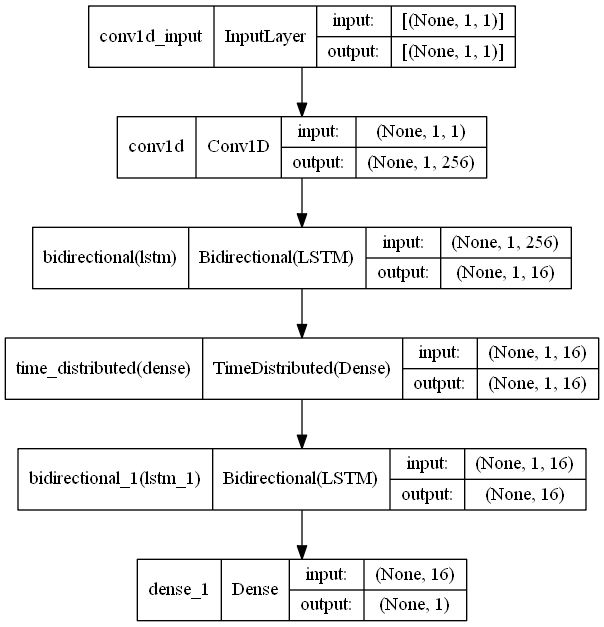

In [21]:
from keras.utils.vis_utils import plot_model
import pydot
import pydotplus
import graphviz

plot_model(model, to_file='./Result/CNN+LSTM/model.png')
plot_model(model, to_file='./Result/CNN+LSTM/model_shapes.png', show_shapes=True)

#### 학습

In [ ]:
#early_stop = EarlyStopping(monitor='val_loss', patience=20)

with tf.device('/GPU:0'):
    model_path = 'model'
    filename = os.path.join(model_path, 'tmp_checkpoint_CL.h5')
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
    history = model.fit(train_data, epochs=5, batch_size=BATCH_SIZE, validation_data=(valid_data), callbacks=[checkpoint])

Epoch 1/5
    144/Unknown - 11s 35ms/step - loss: 0.0907
Epoch 00001: val_loss improved from inf to 0.08583, saving model to model\tmp_checkpoint_CL.h5
144/144 [==============================] - 13s 50ms/step - loss: 0.0907 - val_loss: 0.0858
Epoch 2/5
143/144 [============================>.] - ETA: 0s - loss: 0.0821
Epoch 00002: val_loss improved from 0.08583 to 0.08564, saving model to model\tmp_checkpoint_CL.h5
144/144 [==============================] - 6s 39ms/step - loss: 0.0821 - val_loss: 0.0856
Epoch 3/5
 17/144 [==>...........................] - ETA: 4s - loss: 0.0927

In [ ]:
model.load_weights(filename)
pred = model.predict(test['Watt'])

pred.shape

### 9. 결과 표시

In [ ]:
try:
    os.mkdir('./Result')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

In [ ]:
try:
    os.mkdir('./Result/CNN+LSTM')
    os.mkdir('./Result/CNN+LSTM/Graph')
    os.mkdir('./Result/CNN+LSTM/Data')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

In [ ]:
plt.figure(figsize=(16, 10))
plt.title('Model Validation Loss', size='15')
plt.xlabel('Epoch')
plt.ylabel('Val_loss')
plt.grid(True)
plt.plot(history.history['val_loss'])
plt.margins(x=0.02)
plt.savefig('./Result/CNN+LSTM/Graph/Model_Valdation_Loss.png')
plt.show

In [ ]:
plt.figure(figsize=(16, 10))
plt.title('Model Loss Convergence Graph', size='15')
y_tloss = history.history['loss']
y_vloss = history.history['val_loss']
x_len = np.arange(len(y_tloss))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(range(0,20), labels=range(1,21))

# 그래프의 가시성을 높이기 위해 초반의 급격한 감소를 그래프에서 삭제하고 세밀한 변화를 위주로 표현
y_tloss=y_tloss[1:]
y_vloss=y_vloss[1:]
x_len=x_len[1:]

plt.plot(x_len, y_tloss, "o-", c="blue", markersize=3)
plt.plot(x_len, y_vloss, "o-", c="red", markersize=3)
plt.margins(x=0.02)
plt.legend(['Training loss', 'Validation loss'])
plt.savefig('./Result/CNN+LSTM/Graph/Model_Loss_Convergence_Graph.png')
plt.show

In [ ]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', colors='blue', size=15)
plt.tick_params(axis='x', colors='blue', labelsize=12)
plt.tick_params(axis='y', colors='blue', size=15)
plt.tick_params(axis='y', colors='blue', labelsize=12)

plt.plot(pred, label = 'Prediction',color='blue')

plt.xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], labels=['0', '2000 W', '3500 W', '5500 W', '7000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Prediction.png')
plt.show()

In [ ]:
plt.figure(figsize=(300, 15))

plt.tick_params(axis='x', colors='darkorange', size=15)
plt.tick_params(axis='x', colors='darkorange', labelsize=12)
plt.tick_params(axis='y', colors='darkorange', size=15)
plt.tick_params(axis='y', colors='darkorange', labelsize=12)

x=test['Graph_Date']

plt.plot(test['Watt'], label = 'Actual', color='darkorange')

#plt.xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.yticks([0, 0.2, 0.4, 0.6, 0.8], labels=['0', '2000 W', '3500 W', '5500 W', '7000 W'])

plt.margins(x=0.005)
plt.savefig('./Result/CNN+LSTM/Graph/Actual.png')
plt.show()

In [ ]:
fig = plt.figure(figsize=(300,15)) 
ax1 = fig.add_subplot() # subplot 그래프 생성
ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8], labels=['0', '2000 W', '3500 W', '5500 W', '7000 W'])

color1 = 'darkorange'
ax1.plot(test['Watt'], color=color1)
#ax1.set_ylabel('y', size=20)
ax1.tick_params(axis='y')
ax1.tick_params(axis='x', size=20, labelsize=20)
ax1.margins(x=0.005)
ax1.set_xticks([26280, 26280+31*24, 26280+59*24, 26280+90*24, 26280+120*24, 26280+151*24, 26280+181*24, 26280+212*24, 26280+243*24, 26280+273*24, 26280+304*24, 26280+334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # x1의 칸당 간격(=ticks) 설정
ax1.legend(['Actual'], loc=1, bbox_to_anchor=(0.995, 1, 0, 0))

color2 = 'blue'
ax2 = ax1.twiny()
ax2.plot(pred, color=color2)
ax2.tick_params(axis='x', size=20, labelsize=20)
ax2.margins(x=0.005)
ax2.set_xticks([0, 31*24, 59*24, 90*24, 120*24, 151*24, 181*24, 212*24, 243*24, 273*24, 304*24, 334*24], 
           labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']) # x1의 칸당 간격(=ticks) 설정
ax2.legend(['Predict'], loc=1, bbox_to_anchor=(1, 1, 0, 0))

plt.savefig('./Result/CNN+LSTM/Graph/Pred_with_Actual.png')
plt.show()

In [ ]:
# 월 단위 그래프 분할 표시 및 저장
for m in range(1,13):
    month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    
    start = {1:0, 2:744, 3:1416, 4:2160, 5:2880, 6:3624, 7:4344, 8:5088, 9:5832, 10:6552, 11:7296, 12:8016}
    end = {1:744, 2:1416, 3:2160, 4:2880, 5:3624, 6:4344, 7:5088, 8:5832, 9:6552, 10:7296, 11:8016, 12:8760}
        
    ax2.set_title('Prediction & Actual Graph - month'+str(m), size='15')
    
    watt_list=test['Watt'].tolist()
    
    fig = plt.figure(figsize=(30,12)) 
    ax1 = fig.add_subplot() # subplot 그래프 생성
    ax1.tick_params(axis='y', size=20, labelsize=20) # y축 눈금 표기 설정
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8], labels=['0', '2000 W', '3500 W', '5500 W', '7000 W'])

    # Actual
    color1 = 'darkorange'
    ax1.plot(watt_list[start[m]:end[m]], color=color1, marker='.')
    ax1.tick_params(axis='x', size=20, labelsize=20)
    ax1.margins(x=0.005)
    ax1.legend(['Actual'], loc=1, bbox_to_anchor=(0.95, 1, 0, 0))
    
    # Predict
    color2 = 'blue'
    ax2 = ax1.twiny()
    ax2.plot(pred[start[m]:end[m]], color=color2, marker='.')
    ax2.tick_params(axis='x', size=20, labelsize=20)
    ax2.xaxis.set_visible(False)
    ax2.margins(x=0.005)
    ax2.legend(['Predict'], loc=1, bbox_to_anchor=(1, 1, 0, 0))
    
    # 월별 xticks 설정 함수
    def xticks_list (days):
        xticks_list=[]
        for x in range(0,days+1):
            xticks_list.append(x*24)
        return xticks_list
    
    # month labels 설정 함수
    def month_labels (days):
        month_labels=[]
        for ml in range(1,days+1):
            month_labels.append(ml)
        month_labels.append('end') 
        return month_labels
    
    if (m==2):
        ax1.set_xticks(xticks_list(28), labels=month_labels(28))

    if (m==4 or m==6  or m==9 or m==11):
        ax1.set_xticks(xticks_list(30), labels=month_labels(30))
        
    if (m==1 or m==3 or m==5 or m==7 or m==8 or m==10 or m==12):
        ax1.set_xticks(xticks_list(31), labels=month_labels(31))
        
    ax1.set_yticks([0, 0.2, 0.4, 0.6, 0.8], labels=['0', '2000 W', '3500 W', '5500 W', '7000 W'])
    
    plt.suptitle('Prediction_with_Actual_'+str(m),fontsize=20)
    plt.grid(True)
    plt.savefig('./Result/CNN+LSTM/Graph/Prediction_with_Actual_'+str(m)+'.png')
    plt.show()

#### 그래프 비교 결과

In [ ]:
import cv2
from skimage.metrics import structural_similarity as ssim

In [ ]:
# 유사도 측정을 위한 이미지 가공
image1 = cv2.imread('./Result/CNN+LSTM/Graph/Prediction.png')
image2 = cv2.imread('./Result/CNN+LSTM/Graph/Actual.png')

tempDiff1 = cv2.subtract(image1, image2)

gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

In [ ]:
# 차이 추출을 위한 뺄셈 과정
pred_list=pred.tolist()
actual_list=test['Watt'].tolist()

In [ ]:
(score, diff) = ssim(gray1, gray2, full=True)
sim_score = round(score,5)*100

print('그래프 유사도 ==>> %.3f %%' %sim_score)

#### 성능 측정 지표

In [ ]:
true = test['Watt'].to_numpy()
true = true.reshape(-1,1)

In [ ]:
from sklearn.metrics import r2_score as r2
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE

MAE = MAE(true, pred)
RMSE = np.sqrt(MSE(true, pred))

print('r2 >> %.4f' %r2(true, pred)) # 1에 가까워야 좋음
print('MAE >> %.4f' %MAE) # 0에 가까워야 좋음
print('RMSE >> %.4f' %RMSE) # 0에 가까워야 좋음

In [ ]:
MAE_pct = round(1-MAE, 5)*100
RMSE_pct = round(1-RMSE, 5)*100
print('MAE 측정 정확도 ==>> %.3f %%' %MAE_pct)
print('RMSE 측정 정확도 ==>> %.3f %%' %RMSE_pct)

### 10. 예측값과 실제값 결과 csv 파일 저장

#### 1년 단위 데이터 저장

In [ ]:
# 날짜 정보 생성
month = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
datetime_list=[]

for m in range(1, 13):
    month = {1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    for d in range(month[m]):
        d=d+1
        m=int(m)
        d=int(d)
        
        if m<=9:
            m='0'+str(m)
        if d<=9:
            d='0'+str(d)
            
        for h in range(1,25):
            elem = '2016'+'년-'+str(m)+'월-'+str(d)+'일-'+str(h)+'시'
            datetime_list.append(elem)

In [ ]:
# 넘파이 어레이를 데이터 프레임으로 변환
pred_df = pd.DataFrame(pred)
actual_df = pd.DataFrame(watt_list)

In [ ]:
df_for_chart = pd.DataFrame(columns=['datetime', 'pred', 'actual'])
df_for_chart['datetime']=datetime_list
df_for_chart['pred']=pred_df
df_for_chart['actual']=actual_df
df_for_chart.to_csv("./Result/CNN+LSTM/Data/Electric_Prediction_result_data_for_Chart_Year.csv", encoding='cp949')

print('Job Done!!')

#### 1달 단위 데이터 저장

In [ ]:
pred_list=pred_df[0].tolist()
actual_list=actual_df[0].tolist()

for m in range(1,13):
    m=int(m)
    month = {0:0, 1:31, 2:28, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}
    start = {1:0, 2:744, 3:1416, 4:2160, 5:2880, 6:3624, 7:4344, 8:5088, 9:5832, 10:6552, 11:7296, 12:8016}
    end = {1:744, 2:1416, 3:2160, 4:2880, 5:3624, 6:4344, 7:5088, 8:5832, 9:6552, 10:7296, 11:8016, 12:8760}
    
    df_for_chart = pd.DataFrame(columns=['datetime', 'pred', 'actual'])
    df_for_chart['datetime']=datetime_list[start[m]:end[m]]
    df_for_chart['pred']=pred_list[start[m]:end[m]]
    df_for_chart['actual']=actual_list[start[m]:end[m]]
    
    if m<=9:
        m=str(m)
        m='0'+m
        
    df_for_chart.to_csv("./Result/CNN+LSTM/Data/Electric_Prediction_result_data_for_Chart_"+str(m)+".csv", encoding='cp949')
    
print('Job Done!!')

#### 일주일 단위 데이터 저장

In [ ]:
try:
    os.mkdir('./Result/CNN+LSTM/Data/Week')
    print('폴더 생성 완료.')
    
except FileExistsError:
    print('해당 폴더가 이미 존재합니다.')

In [ ]:
count=0
for w in range(0, 8760-168, 168):
    count=int(count)
    count+=1
    start=w
    end=w+168
    
    df_for_chart = pd.DataFrame(columns=['datetime', 'pred', 'actual'])
    df_for_chart['datetime']=datetime_list[start:end]
    df_for_chart['pred']=pred_list[start:end]
    df_for_chart['actual']=actual_list[start:end]
    
    if count<=9:
        count=str(count)
        count='0'+count
        
    df_for_chart.to_csv("./Result/CNN+LSTM/Data//Week/Electric_Prediction_result_data_for_Chart_"+str(count)+".csv", encoding='cp949')
    
print('Job Done!!')